# Fall 2019 CX4641/CS7641 Homework 3

## Instructor: Dr. Mahdi Roozbahani

## Deadline: Nov 7, Thursday, 11:59 pm

* No unapproved extension of the deadline is allowed. Late submission will lead to 0 credit. 

* Discussion is encouraged, but each student must write his own answers and explicitly mention any collaborators.

* Homework submission ONLY in .ipynb format.  You don't need to submit the image.

## Programming (100pts)

## 1 Principal Component Analysis [20pts]


### Environment Setup

In [2]:
import os
from scipy import ndimage, misc
from matplotlib import pyplot as plt
import numpy as np
import imageio
from sklearn.datasets import load_boston, load_diabetes, load_digits, load_breast_cancer
%matplotlib inline

## Load images data and plot
We load the dataset we will deal with, and show the image

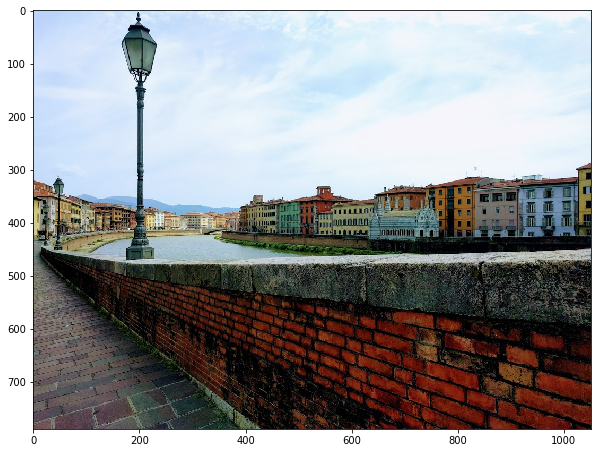

In [23]:
image = plt.imread("hw_3_img.jpg")/255.
fig = plt.figure(figsize=(10,10))
plt.imshow(image)

We can transfer the image to grayscale as follows:

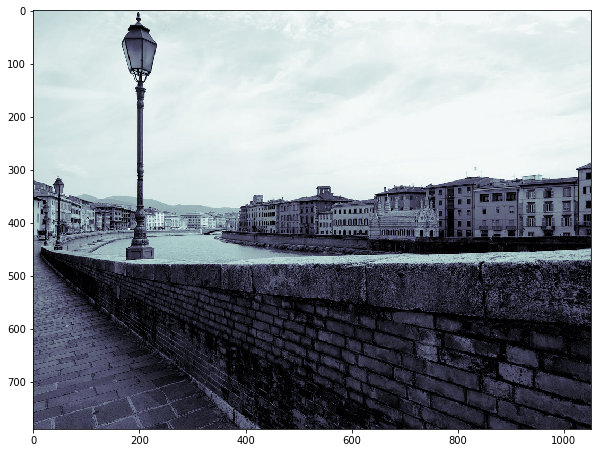

In [24]:
def rgb2gray(rgb):   
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

fig = plt.figure(figsize=(10, 10))
# plot several images
plt.imshow(rgb2gray(image), cmap=plt.cm.bone)

### Image compression

The SVD allows us to compress an image by throwing away the least important information.  The greater the singular values -> the great the variance -> most information from the corresponding singular vector.

SVD each matrix and get rid of the small singular values to compress the image. The loss of inforamtion is negligible as the difference is very difficult to be spotted. 

[Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)(PCA) follows the same process to elimate the small variance eigenvalues and their vectors.  With PCA, we center the data first by subtracting the mean.

Each singular value tells us how much of the variance of a matrix (e.g. image) is captured in each component.  For example, the variance captured by the first component is $$\frac{\sigma_1}{\sum_{i=1}^n \sigma_i}$$ where $\sigma_i$ is the $i^{th}$ singular value.

You need to finish the following functions to do SVD and then reconstruct the image by components.

In [27]:
def svd(X):
    """
    Do SVD. You could use numpy SVD.
    Your function should be able to handle black and white 
    images (N*D arrays) as well as color images (N*D*3 arrays)

    In the image compression, we assume that each coloum of the image is a feature. Image is the matrix X.
    
    Args: 
        X: N * D array corresponding to an image (N*D*3 if color image)
    Return:
        U: N*N (*3 for color images) 
        S: min(N, D)*1 (*3 for color images)
        V: D*D (*3 for color images)
    """
    #X_mean=np.mean(X,axis=0)
    #X=X-X_mean
    #N,D=X.shape
    #C=np.dot(X.transpose(),X)/N
    a=np.array(X.shape).shape[0]
    if a==2:
        U,S,V=np.linalg.svd(X)
    else:
        N=X.shape[0]
        D=X.shape[1]
        U=np.zeros((N,N,3))
        tmp=min(N,D)
        S=np.zeros((tmp,1,3))
        V=np.zeros((D,D,3))
        for i in range (0,3):
            X0=X[:,:,i]
            U0, S0, V0= np.linalg.svd(X0)
            U[:,:,i]=U0
            S[:,0,i]=S0
            V[:,:,i]=V0
    return U,S,V
    #raise NotImplementedError

def rebuildsvd(U, S, V, k):
    """
    Rebuild SVD by k componments.
    Args: 
        U: N*N (*3 for color images) 
        S: min(N, D)*1 (*3 for color images)
        V: D*D (*3 for color images)  
        k: int corresponding to number of components
    Return:
        Xrebuild: N*D array of reconstructed image (N*D*3 if color image)
        
    Hint: numpy.matmul may be helpful for reconstructing color images
    """
    N=U.shape[0]
    D=V.shape[0]
    
    b=np.array(U.shape).shape[0]
    if b==2:
        a=np.zeros((N,D))
        for i in range (0,k):
            Uk=U[:,i].reshape(N,1)
            Vk=V[i].reshape(1,D)
            a+=S[i]*np.dot(Uk,Vk)
        a[a<0]=0
        a[a>255]=255
    else:
        a=np.zeros((N,D,3))
        for c in range(0,3):
            U0=U[:,:,c]
            S0=S[:,0,c]
            V0=V[:,:,c]
            for i in range (0,k):
                Uk=U0[:,i].reshape(N,1)
                Vk=V0[i,:].reshape(1,D)
                a[:,:,c]+=S0[i]*np.dot(Uk,Vk)
                #a[:,:,c]+=S0[i]*(Uk@Vk）
    return a
    #raise NotImplementedError

def compression_ratio(X, k):
    """
    Compute compression of an image: (num stored values in original)/(num stored values in compressed)
    Args: 
        X: N * D array corresponding to an image (N * D * 3 if color image)
        k: int corresponding to number of components
    Return:
        compression_ratio: float of proportion of storage used by compressed image
    """
    N=X.shape[0]
    D=X.shape[1]
    image_size=N*D
    compressed_size=k*(1+N+D)
    compressed_ratio=compressed_size/image_size
    return compressed_ratio
    
    #raise NotImplementedError

def recovered_variance_proportion(S, k):
    """
    Compute the proportion of the variance in the original matrix recovered by a rank-k approximation
    
    Args:
       S: min(N, D)*1 (*3 for color images) of singular values for the image
       k: int, rank of approximation
    Return:
       recovered_var: int (array of 3 ints for color image) corresponding to proportion of recovered variance
    """
    a=np.array(S.shape).shape[0]
    if a==1:
        Sk=S[0:k]
        S1=np.sum(Sk)
        S2=np.sum(S)
        recovered_var=S1/S2
    else:
        recovered_var=[]
        for i in range (0,3):
            S_1=np.sum(S[0:k,0,i])
            S_2=np.sum(S[:,0,i])
            S_3=S_1/S_2
            recovered_var.append(S_3)
        recovered_var=np.array(recovered_var)    
    return  recovered_var
    #raise NotImplementedError

**Now let see the results for image reconstruction.**  
1) Black and White

bw= (789, 1052)


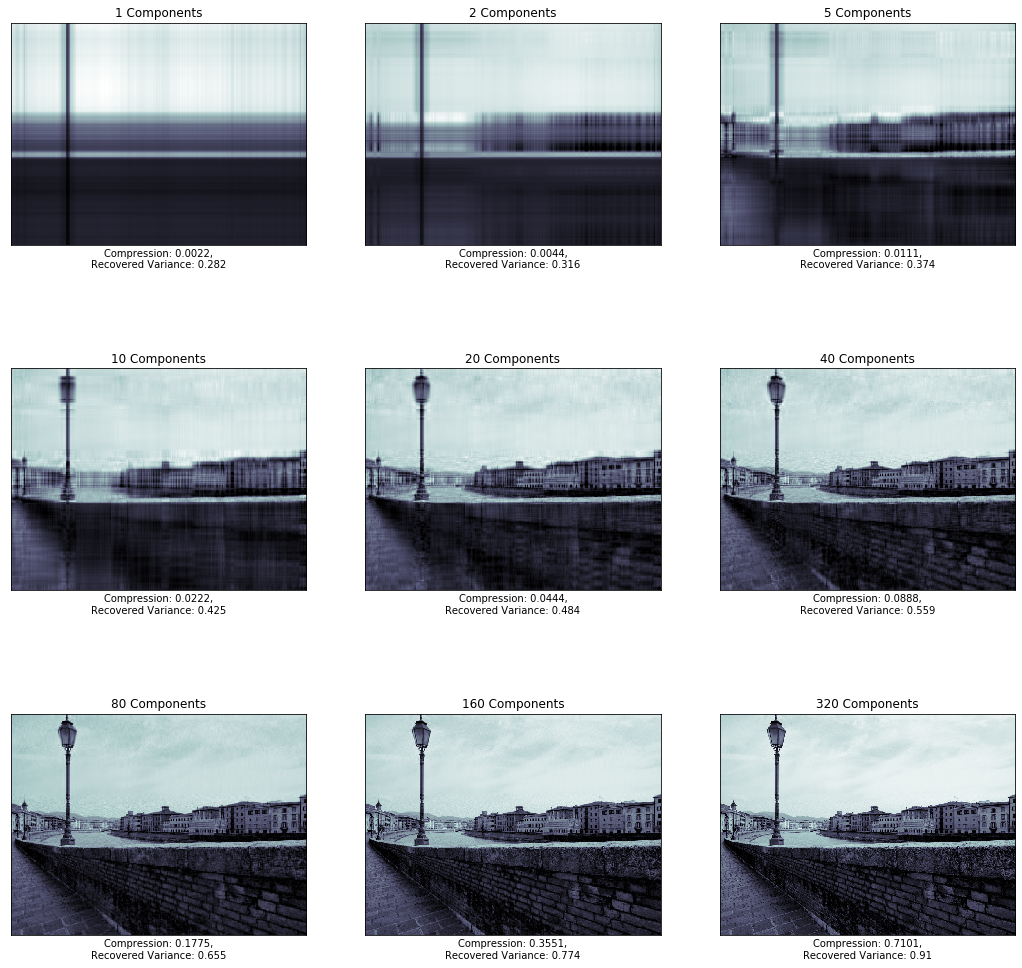

In [28]:
#helper do not need to change

bw_image = rgb2gray(image)
print("bw=",bw_image.shape)
U, S, V = svd(bw_image)
#print(U.shape)
#print(S.shape)
#print(V.shape)

component_num = [1,2,5,10,20,40,80,160,320]

fig = plt.figure(figsize=(18, 18))

# plot several images
i=0
for k in component_num:
    img_rebuild = rebuildsvd(U, S, V, k)
    #print(img_rebuild.shape)
    c = np.around(compression_ratio(image, k), 4)
    r = np.around(recovered_variance_proportion(S, k), 3)
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img_rebuild, cmap=plt.cm.bone)
    ax.set_title(f"{k} Components")
    ax.set_xlabel(f"Compression: {c},\nRecovered Variance: {r}")
    i = i+1

2) Color

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


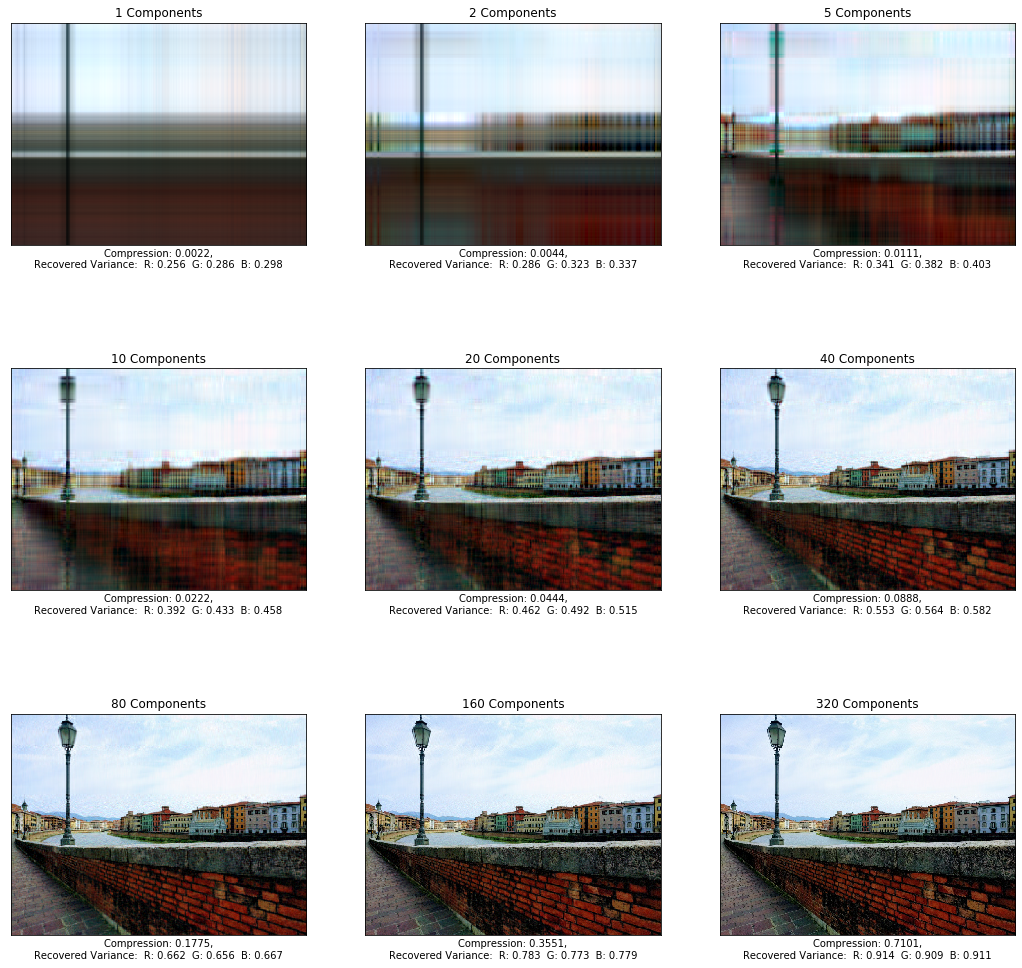

In [29]:
#helper do not need to change

U, S, V = svd(image)
component_num = [1,2,5,10,20,40,80,160,320]

fig = plt.figure(figsize=(18, 18))

# plot several images
i=0
for k in component_num:
    img_rebuild = rebuildsvd(U, S, V, k)
    c = np.around(compression_ratio(image, k), 4)
    r = np.around(recovered_variance_proportion(S, k), 3)
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img_rebuild)
    ax.set_title(f"{k} Components")
    ax.set_xlabel(f"Compression: {np.around(c,4)},\nRecovered Variance:  R: {r[0]}  G: {r[1]}  B: {r[2]}")
    i = i+1

## 2 Polynomial Regression with Regualrization [35pts + 20pts]

#### 2.1 Helper functions [10pts]
1) RMSE [5pts] 

In [3]:
def rmse(pred, label): 
    '''
    This is the root mean square error.
    Args:
        pred: numpy array of length N * 1, the prediction of labels
        label: numpy array of length N * 1, the ground truth of labels
    Return:
        a float value
    '''
    #n=pred.shape[0]
    #numer=np.sum ((label-pred)**2)
    #rmse=np.sqrt(numer/n)
    #return rmse
    #raise NotImplementedError
    return np.sqrt(np.mean(np.square(pred-label)))

# Hint: get the sqaure root of theta hat in slide 14 (https://mahdi-roozbahani.github.io/cse4240-spring2019.github.io/course/14-linear-regression.pdf)
prediction = np.array([1, 2, 3]) 
label = np.array([1.5, 2.5, 3.5])
#prediction=np.array([1,1,1,1])
#label=np.array([0,0,0,0])
print('rmse =',rmse(prediction, label))

rmse = 0.5


Do you know whether this RMSE is good or not? If you don't know, we could normalize our labels between 0 and 1. After normalization, what does it mean when RMSE = 1? 

**Hint**: think of the way that you can enforce your RMSE = 1. Note that you can not change the actual labels to make RMSE = 1.

When the prediction and label y are normalize between 0 and 1, the maximum misfit can be achieved is 1. For example, if there are :
$$label=[1,1,1,1]$$ but the prediction is 
$$prediction=[0,0,0,0]$$
Then, the RMSE woule equal to 1.

After normalization,  $prediction = [ 0, \frac{1}{2}, 1]  , label= [ 0,\frac{1}{2},1]$ the RMSE would be 0. Thus, the prediction is good.

2) Construct polynomial features [5pts]

In [4]:
def construct_polynomial_feats(x, degree):
    """
    Args:
        x: numpy array of length N, the 1-D observations
        degree: the max polynomial degree
    Return:
        feat: numpy array of shape Nx(degree+1), remember to include 
        the bias term. feat is in the format of:
        [[1.0, x1, x1^2, x1^3, ....,],
         [1.0, x2, x2^2, x2^3, ....,],
         ......
        ]
    """
    m=x.shape[0]
    x_re=np.ones((m,degree+1))
    x_re[:,1]=x
    for i in range(0,m):
        for j in range (1,degree+1):
            x_re[i,j]=np.power(x_re[i,1] ,j)
    return x_re
        
    raise NotImplementedError
# Here there are two data points. One data point is 0.5 and other one is 0.2. 
# We try to represent these two data points in higher dimensions.

x = np.array([0.5, 0.2]) 
x_feat = construct_polynomial_feats(x, 4)
print(x_feat)

[[1.     0.5    0.25   0.125  0.0625]
 [1.     0.2    0.04   0.008  0.0016]]


In [5]:
#helper do not need to change
def plot_curve(x, y, curve_type='.', color='b', lw=2):
    plt.plot(x, y, curve_type, color=color, linewidth=lw)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)

#### 2.2 Linear Regression [10pts + 10pts]

We have three methods to fit linear gression model: 1) close form; 2)Gradient descent (GD); 3) Stochastic gradient descent (SGD). For undergraduate students, you are required to implement 1), and the other two are bonus parts; for graduate students, you are required to implement all of them. Each method has 5 points.

After fitting the model, we need to implement the prediction function. [5pts]

In [6]:
class LinearReg(object):
    @staticmethod 
    # static method means that you can use this method or function for any other classes, it is not specific to LinearReg
    def fit_closed(xtrain, ytrain):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytarin: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        
        N,D=xtrain.shape
        weight = np.zeros((D,1))
        weight=np.linalg.inv(np.transpose(xtrain) @ xtrain)@np.transpose(xtrain)@ytrain
        #b=a@np.transpose(xtrain)
        #weigt=b@ytrain
        return weight
        
    #raise NotImplementedError
        
    @staticmethod
    def fit_GD(xtrain, ytrain, epochs=5000000, learning_rate=1e-7):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        
        N,D=xtrain.shape
        '''
        weight = np.ones((D,1))
        rmses=[]
        for times in range (0,epochs):
           
            sum=0
            for  i in range (0,N):
                 sum=sum+ (xtrain[i,:].T)*(ytrain[i]-xtrain[i,:]@weight)
            tmp=(learning_rate/N)*sum
            weight=weight+tmp
            #wight=weight+(learning_rate/N)*(np.transpose(xtrain)@(ytrain-(xtrain@weight)))
                   
            
            #hypothesis = np.dot(xtrain, weight)
            #loss = ytrain-hypothesis 
            #gradient = learning_rate*np.dot(xtrain.T, loss) / N
            weight = weight + learning_rate*np.dot(xtrain.T, ytrain-np.dot(xtrain, weight)) / N
            rmses.append(rmse(np.dot(xtrain,weight),ytrain))   
        '''
        rmses=[] 
        weight=np.zeros((D,1)) 
        for i in range(epochs):
            weight = weight + learning_rate*np.dot(xtrain.T, ytrain-np.dot(xtrain, weight)) / N
            rmses.append(rmse(np.dot(xtrain,weight),ytrain)) 
        return weight,rmses
    
    #raise NotImplementedError

    @staticmethod
    def fit_SGD(xtrain, ytrain, epochs=1000, learning_rate=1e-7):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        [N,D]=xtrain.shape
        weight = np.zeros((D,1))
        rmses=[] 
        for i in range (epochs):
            #posi=np.random.randint(0,N)
            for j in range(0,N):
                #hypothesis = np.dot(xtrain[posi,:], weight)
                #loss = ytrain[posi,:]-np.dot(xtrain[posi,:], weight)
                gradient = np.dot(xtrain[j:j+1].T,ytrain[j:j+1]-np.dot(xtrain[j:j+1],weight))
                #print(gradient)
                weight= weight+learning_rate*gradient
            rmses.append(rmse(np.dot(xtrain,weight),ytrain)) 
            
            '''
            k=i%N
            weight=weight + (learning_rate)*((xtrain[k,:])*(ytrain[k]-xtrain[k,:]@weight))
            '''
        return weight,rmses
    #raise NotImplementedError

    @staticmethod
    def predict(xtest, weight):
        """
        Args:
            xtest: NxD numpy array, where N is number 
                   of instances and D is the dimensionality of each 
                   instance
            weight: Dx1 numpy array, the weights of linear regression model
        Return:
            prediction: Nx1 numpy array, the predicted labels
        """
        #N,D=xtest.shape
        #ytest=np.zeros((N,1))
        #ytest=xtest@weight
        return np.dot(xtest,weight)
            
    #raise NotImplementedError
        
# Hint: in the fit function, use close form solution of the linear regression to get weights. 
# For inverse, you can use numpy linear algebra function  
# For the predict, you need to use linear combination of data points and their weights (y = w0*1+w1*X1+...)

Let's first construct a dataset for polynomial regression.

In this case, we construct the polynomial features up to degree 5, where the groundtruth function is just a linear function (i.e., only require polynomial features up to degree 1).

[[0.96702984]
 [0.54723225]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


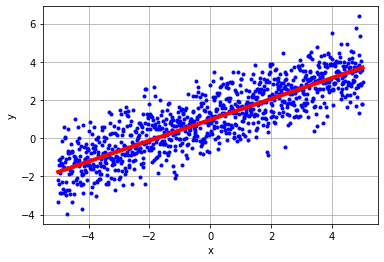

In [7]:
#helper, do not need to change

POLY_DEGREE = 5
NUM_OBS = 1000

rng = np.random.RandomState(seed=4)

true_weight = rng.rand(POLY_DEGREE + 1, 1)
true_weight[2:, :] = 0
print(true_weight)
x_all = np.linspace(-5, 5, NUM_OBS)
#print(x_all.shape)
x_all_feat = construct_polynomial_feats(x_all, POLY_DEGREE)
#print(x_all_feat.shape)
#print(x_all_feat[0,:])
y_all = np.dot(x_all_feat, true_weight) + rng.randn(x_all_feat.shape[0], 1) # in the second term, we add noise to data
# Note that here we try to produce y_all as our training data
plot_curve(x_all, y_all) # Data with noise that we are going to predict
plot_curve(x_all, np.dot(x_all_feat, true_weight), curve_type='-', color='r', lw=4) # the groundtruth information

indices = rng.permutation(NUM_OBS)

In the figure above, the red curve is the true fuction we want to learn, while the blue dots are the noisy observations. The observations are generated by $Y = XW + \sigma$, where $\sigma \sim \mathcal{N}(0, 1)$ are i.i.d. generated noise. 

Now let's split the data into two parts, namely the training set and test set. The red dots are for training, while the blue dots are for testing.

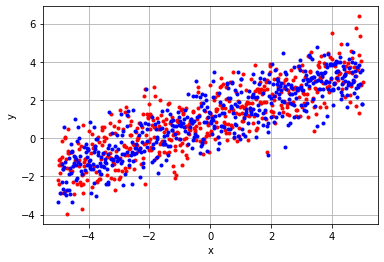

In [8]:
#helper, do not need to change

train_indices = indices[:NUM_OBS//2]
test_indices = indices[NUM_OBS//2:]

plot_curve(x_all[train_indices], y_all[train_indices], color='r')
plot_curve(x_all[test_indices], y_all[test_indices], color='b')

Now let's first train using the entire training set, and see how we performs on the test set and how the learned function look like.

In [9]:
#helper, do not need to change

weight = LinearReg.fit_closed(x_all_feat[train_indices], y_all[train_indices])
y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

test rmse: 0.9222


test rmse: 1.1695


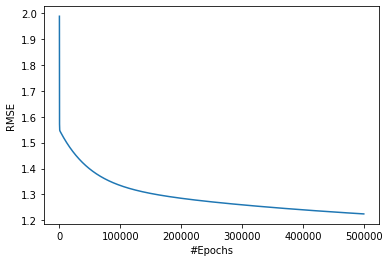

In [19]:
epochs=[]
RMSE=[]
'''
for i in range(1,100):
    #print("i=",i)
    weight = LinearReg.fit_GD(x_all_feat[train_indices], y_all[train_indices], epochs=5000*i, learning_rate=1e-6)#1e-7
    #print("epochs=",epochs)
    y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
    test_rmse = rmse(y_test_pred, y_all[test_indices])
    #print(test_rmse)
    epochs.append(500*i)
    RMSE.append(test_rmse)
'''
weight,rmses = LinearReg.fit_GD(x_all_feat[train_indices], y_all[train_indices], epochs=500000, learning_rate=1e-7)
plt.plot(np.arange(500000),np.array(rmses))
#plt.plot(epochs,RMSE)
plt.xlabel('#Epochs')
plt.ylabel('RMSE ')
y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

test rmse: 1.1695


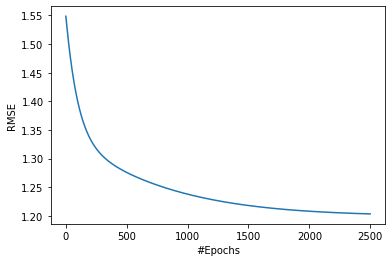

In [21]:
'''
weight = LinearReg.fit_SGD(x_all_feat[train_indices], y_all[train_indices], epochs=2500, learning_rate=1e-7)
y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)
'''
'''
epochs=[]
RMSE=[]
for i in range(1,100):
    weight = LinearReg.fit_SGD(x_all_feat[train_indices], y_all[train_indices], epochs=25*i, learning_rate=1e-9)
    #print(weight)
    y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
    #print("i=",i)
    test_rmse = rmse(y_test_pred, y_all[test_indices])
    #print(test_rmse)
    epochs.append(25*i)
    RMSE.append(test_rmse)
plt.plot(epochs,RMSE)
#plt.plot(RMSE,epochs)
print('test rmse: %.4f' % test_rmse)
'''
weight, rmses = LinearReg.fit_SGD(x_all_feat[train_indices], y_all[train_indices], epochs=2500, learning_rate=1e-7)
plt.plot(np.arange(2500),np.array(rmses))
#plt.plot(epochs,RMSE)
plt.xlabel('#Epochs')
plt.ylabel('RMSE')
print('test rmse: %.4f' % test_rmse)



And what if we just use the first 10 observations to train? 

In [43]:
sub_train = train_indices[:10]
weight = LinearReg.fit_closed(x_all_feat[sub_train], y_all[sub_train])
#weight= LinearReg.fit_GD(x_all_feat[sub_train], y_all[sub_train],epochs=5000*200, learning_rate=1e-6)
#weight= LinearReg.fit_SGD(x_all_feat[sub_train], y_all[sub_train],epochs=2500, learning_rate=1e-9)
y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

test rmse: 2.1910


Did you see a worse performance? Let's take a closer look at what we have learned.

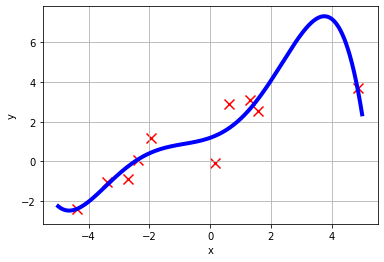

In [44]:
#helper, do not need to change

y_pred = LinearReg.predict(x_all_feat, weight)
plot_curve(x_all, y_pred, curve_type='-', color='b', lw=4)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)

#### 2.3 Ridge Regression [5pts + 10pts]

Now let's try ridge regression. Similarly, undergraduate students need to implement the close form, and graduate students need to implement all the three methods. We will call the prediction function from linear regression part.

In [10]:
class RidgeReg(LinearReg):

    @staticmethod
    def fit_closed(xtrain, ytrain, c_lambda):
        N,D=xtrain.shape
        weight=np.zeros((D,1))
        I=np.identity(D)
        I[0,:]=0
        weight=np.linalg.inv(np.transpose(xtrain) @ xtrain+c_lambda*I)@np.transpose(xtrain)@ytrain
        return weight
        raise NotImplementedError
    
    @staticmethod
    def fit_GD(xtrain, ytrain, c_lambda, epochs=100, learning_rate=0.001):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        N,D=xtrain.shape
        weight=np.zeros((D,1))
        c_lambda=np.ones(weight.shape)*c_lambda
        c_lambda[0,0]=0.0
        for i in range(0,epochs):
            loss=-(np.transpose(xtrain)@(ytrain-xtrain@weight)+c_lambda*weight)/xtrain.shape[0]
            weight=weight-learning_rate*loss
            
        return weight
        #raise NotImplementedError
    
    @staticmethod
    def fit_SGD(xtrain, ytrain, c_lambda, epochs=100, learning_rate=0.001):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        N,D=xtrain.shape
        weight=np.zeros((D,1))
        c_lambda=np.ones(weight.shape)*c_lambda
        c_lambda[0,0]=0.0
        for i in range(0,epochs):
            for k in range (0,N):
                #a=(ytrain[k]-np.dot(xtrain[k,:], weight))
                #b=c_lambda*weight
                regulizer=(2*c_lambda/N)*weight
                regulizer[0,0]=0
                loss=-xtrain[k,:].reshape(D,1)*(ytrain[k]-np.dot(xtrain[k:k+1,:], weight))+regulizer
                weight=weight-learning_rate*loss
           
        return weight
        raise NotImplementedError

Again, let's see what we have learned. You only need to run the cell corresponding to your specific implementation.

test rmse: 1.2115


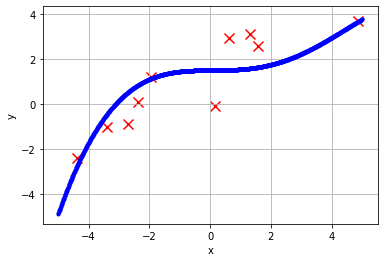

In [46]:
sub_train = train_indices[:10]
weight = RidgeReg.fit_closed(x_all_feat[sub_train], y_all[sub_train], c_lambda=1000)
y_pred = RidgeReg.predict(x_all_feat, weight)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = RidgeReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

test rmse: 1.6672


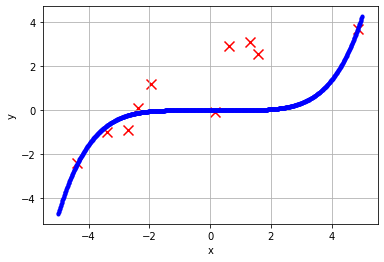

In [11]:
sub_train = train_indices[:10]
weight = RidgeReg.fit_SGD(x_all_feat[sub_train], y_all[sub_train], c_lambda=1000, learning_rate=1e-7)
#print(weight.shape)
y_pred = RidgeReg.predict(x_all_feat, weight)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = RidgeReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

test rmse: 1.6446


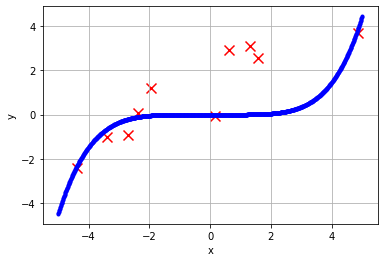

In [48]:
sub_train = train_indices[:10]
weight = RidgeReg.fit_GD(x_all_feat[sub_train], y_all[sub_train], c_lambda=1000, learning_rate=1e-7)
y_pred = RidgeReg.predict(x_all_feat, weight)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = RidgeReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

#### 2.4 Cross Validation [10pts]
Let's use Cross Validation to find the best value for c_lambda. 

In [49]:
# We provided 6 possible values for lambda, and you will use them in cross validation.
# For cross validation, use 10-fold method and only use it for your training data (you already have the train_indices to get training data).
# For the training data, split them in 10 folds which means that use 10 percent of training data for test and 90 percent for training.
# At the end for each lambda, you have caluclated 10 rmse and get the mean value of that.
# That's it. Pick up the lambda with the lowest mean value of rmse. 
# Hint: np.concatenate is your friend.

def cross_validation(X, y, kfold, c_lambda):
    N,D=X.shape
    rmse_set=[]
    numpoint=np.int(N/kfold )#point_number_perfold
    for i in range (kfold):
       # print("i=",i)
        if i==0:
            #print(i*numpoint)
            #print((i+1)*numpoint)
            xtest=X[ : (i+1)*numpoint]
            xtrain=X[(i+1)*numpoint:]
            ytest=y[ : (i+1)*numpoint]
            ytrain=y[(i+1)*numpoint:]
            
            
        elif i==kfold-1:
            xtest=X[i*numpoint : (i+1)*numpoint,:]
            xtrain=X[:(i)*numpoint,:]
            ytest=y[i*numpoint : (i+1)*numpoint,:]
            ytrain=y[:(i)*numpoint,:]
            
        else:
            xtest=X[i*numpoint:(i+1)*numpoint,:]
            x1=X[:i*numpoint]
            x2=X[(i+1)*numpoint:]
            xtrain=np.concatenate((x1,x2),axis=0)
            ytest=y[i*numpoint:(i+1)*numpoint,:]
            y1=y[:i*numpoint,:]
            y2=y[(i+1)*numpoint:,:]
            ytrain=np.concatenate((y1,y2),axis=0)
        weight=RidgeReg.fit_closed(xtrain, ytrain, c_lambda=c_lambda)
        y_test_pred = RidgeReg.predict(xtest, weight)
        rmse_set.append(rmse(y_test_pred,ytest))  
    error=np.mean(rmse_set)
    return error
    #raise NotImplementedError

best_lambda = None
best_error = None
kfold = 10
lambda_list = [0, 0.1, 1, 5, 10, 100, 1000]
for lm in lambda_list:
    err = cross_validation(x_all_feat[train_indices], y_all[train_indices], kfold, lm)
    print('lambda: %.2f' % lm, 'error: %.6f'% err)
    if best_error is None or err < best_error:
        best_error = err
        best_lambda = lm

print('best_lambda: %.2f' % best_lambda)
weight = RidgeReg.fit_closed(x_all_feat[train_indices], y_all[train_indices], c_lambda=10)
y_test_pred = RidgeReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

lambda: 0.00 error: 0.999078
lambda: 0.10 error: 0.999076
lambda: 1.00 error: 0.999057
lambda: 5.00 error: 0.998997
lambda: 10.00 error: 0.998973
lambda: 100.00 error: 1.003054
lambda: 1000.00 error: 1.029322
best_lambda: 10.00
test rmse: 0.9227


## 3 PCA analysis [25 pts]

In this problem, we will investigate how PCA can be used to improve features for regression and classification tasks and how the data itself affects the behavior of PCA.  

**Intrinsic Dimensionality [15pts]**  
Assume a dataset is composed of N datapoints, each of which has D features with D < N.  The *dimension* of our data would be $D$. It is possible, however, that many of these dimensions contain redundant information.  The *intrinsic dimensionality* is the number of dimensions we need to reconstruct our data with high fidelity.  For our purposes, we will define the intrinsic dimension as the number of principal components needed to reconstruct 99% of the variation within our data.  

We define a set of features as linearly independent if we cannot construct one out of a linear combination of the others. The number of linearly independent features is the number of nonzero principal components (where we define 0 is anything less than $10^{-11}$ due to floating point error). Zero principal components mean that we can not find any weights to linearly combine features in order to create an indenpendent feature. Thus, our algorithm will assign 0 to these weights.

In [14]:
def pca(X):
    """
    Decompose dataset into principal components. 
    You may use your SVD function from the previous part in your implementation.
    
    Args: 
        X: N*D array corresponding to a dataset
    Return:
        U: N*N 
        S: min(N, D)*1 
        V: D*D
    """
    U,S,V= np.linalg.svd(X)
    return U,S,V
    
def intrinsic_dimension(S, recovered_variance=.99):
    """
    Find the number of principal components necessary to recover given proportion of variance
    
    Args: 
        S: 1-d array corresponding to the singular values of a dataset
        
        recovered_varaiance: float in [0,1].  Minimum amount of variance 
            to recover from given principal components
    Return:
        dim: int, the number of principal components necessary to recover 
            the given proportion of the variance
    """
    S=S**2
    total_var=np.sum(S)
    cum=0 #cumulative sum
    S=S[np.argsort(S)[::-1]]
    #do the add until hit the threshod
    for i, v in enumerate(S):
        cum=cum+v
        if (cum/total_var>=recovered_variance):
            #i=i+1
            return i+1
    return i+1
    
    #raise NotImplementedError
    
def num_linearly_ind_features(S, eps=1e-11):
    """
    Find the number of linearly independent featues in dataset
    
    Args: 
        S: 1-d array corresponding to the singular values of a dataset
    Return:
        dim: int, the number of linearly independent dimensions in our data
    """
    S=S[np.argsort(S)[::-1]]
    for i, v in enumerate(S):
        if v < eps:
            return i
    return i+1
    #raise NotImplementedError

Use your above functions to find the intrinsic dimensionality and number of linearly independent components in the following datasets:
* Digits (handwritten digits)
* Breast Cancer
* Boston Housing
* Diabetes

In [15]:
#helper, don't need to change
digits = load_digits()
cancer = load_breast_cancer()
boston = load_boston()
diabetes = load_diabetes()

In [16]:
print("Total Features")
print("\tDigits", digits.data.shape[1])
print("\tBreast Cancer", cancer.data.shape[1])
print('\tBoston', boston.data.shape[1])
print('\tDiabetes', diabetes.data.shape[1])

Total Features
	Digits 64
	Breast Cancer 30
	Boston 13
	Diabetes 10


In [17]:
print("Linearly Independent Features:")
print("\tDigits", num_linearly_ind_features(pca(digits.data)[1]))
print("\tBreast Cancer", num_linearly_ind_features(pca(cancer.data)[1]))
print("\tBoston", num_linearly_ind_features(pca(boston.data)[1]))
print("\tDiabetes", num_linearly_ind_features(pca(diabetes.data)[1]))

Linearly Independent Features:
	Digits 61
	Breast Cancer 30
	Boston 13
	Diabetes 10


In [18]:
print("Intrinsic Dimensionality:")
print("\tDigits", intrinsic_dimension(pca(digits.data)[1]))
print("\tBreast Cancer", intrinsic_dimension(pca(cancer.data)[1]))
print("\tBoston", intrinsic_dimension(pca(boston.data)[1]))
print("\tDiabetes", intrinsic_dimension(pca(diabetes.data)[1]))

Intrinsic Dimensionality:
	Digits 33
	Breast Cancer 1
	Boston 2
	Diabetes 8


**Feature Scaling [10pts]**

Principal component analysis is not agnostic to the scale of your features.  Measuring a feature with different units can change your principal components.

For this problem, randomly choose one of your a column in each of the above datasets and multiply it by 1000.  For each of the datasets, answer the following:
1. How does this change the distribution of variance among the first 10 components?  
2. How does this change the first principal component of the data?
3. How does this affect the number of linearly independent components and intrinsic dimensionality?  Why?

It may be helpful to plot the variance captured by each component in a scree plot (see function below) and to make a bar plot of the absolute value of each feature in the first principal component.  

After perturb:
(1797, 64)
(569, 30)
(506, 13)
(442, 10)
Total Features
	Digits 64
	Breast Cancer 30
	Boston 13
	Diabetes 10
First 10 component
The first component: [567138.55426999]
The first component: [1449978.79782987]
The first component: [8416292.36562673]
The first component: [1000000.04038908]


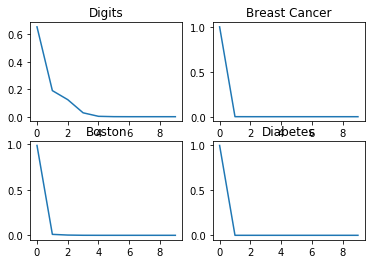

Linearly Independent Features:
	Digits 64
	Breast Cancer 30
	Boston 13
	Diabetes 10
Intrinsic Dimensionality:
	Digits 4
	Breast Cancer 1
	Boston 2
	Diabetes 1


In [24]:
def randomly_perturb_data(data, multiplier=1000):
    """
    Multiply a random column in data by multiplier
    
    Inputs:
        data: N*D numpy array of features
        multiplier: multiplier by which to perturb a random column in data
        
    Returns:
        perturbed_data: Data with random column multiplied by multiplier
    """
    print(data.shape)
    D=data.shape[1]
    tmp=np.random.randint(D,size=1)
    data[:,tmp]*=multiplier
    return data
    
    #raise NotImplementedError
    
def scree_plot(S, n_components=10):
    """
    Plot proportion of variance contained in each individual component
    """
    S=S[np.argsort(S)[::-1]]
    s1=S[:n_components]
    var_proportion=s1**2/np.sum(s1**2)
    #first component
    s_first=S[:1]
    var_proportion_first=s_first**2/np.sum(s_first**2)
    print("The first component:",s_first)
    #plt.figure()
    plt.plot(np.arange(n_components),var_proportion)
    #plt.show()
    
    
    #raise NotImplementedError
print("After perturb:")
digits.data=randomly_perturb_data(digits.data)
cancer.data=randomly_perturb_data(cancer.data)
boston.data=randomly_perturb_data(boston.data)
diabetes.data=randomly_perturb_data(diabetes.data)

print("Total Features")
print("\tDigits", digits.data.shape[1])
print("\tBreast Cancer", cancer.data.shape[1])
print('\tBoston', boston.data.shape[1])
print('\tDiabetes', diabetes.data.shape[1])

print("First 10 component")
fig=plt.figure()
ax=fig.add_subplot(2,2,1)
ax.set_title("Digits")
scree_plot(pca(digits.data)[1])
ax=fig.add_subplot(2,2,2)
ax.set_title("Breast Cancer")
scree_plot(pca(cancer.data)[1])
ax=fig.add_subplot(2,2,3)
ax.set_title("Boston")
scree_plot(pca(boston.data)[1])
ax=fig.add_subplot(2,2,4)
ax.set_title("Diabetes")
scree_plot(pca(diabetes.data)[1])
plt.show()

print("Linearly Independent Features:")
print("\tDigits", num_linearly_ind_features(pca(digits.data)[1]))
print("\tBreast Cancer", num_linearly_ind_features(pca(cancer.data)[1]))
print("\tBoston", num_linearly_ind_features(pca(boston.data)[1]))
print("\tDiabetes", num_linearly_ind_features(pca(diabetes.data)[1]))

print("Intrinsic Dimensionality:")
print("\tDigits", intrinsic_dimension(pca(digits.data)[1]))
print("\tBreast Cancer", intrinsic_dimension(pca(cancer.data)[1]))
print("\tBoston", intrinsic_dimension(pca(boston.data)[1]))
print("\tDiabetes", intrinsic_dimension(pca(diabetes.data)[1]))


Please write your analysis here: 
1. How does this change the distribution of variance among the first 10 components? 

    As you can see, the larger n_component is, the lower the variance propostion and the result would be close to 0 at end. The variance propostion drop sharply at the begining and then nearly stay the same. At the begining, the the variance in the pertubed direction is extremely big thus the variance propostion is high at the first component. 


2. How does this change the first principal component of the data?

    The first principle component of data will become bigger. Because the first principal component of data may be replaced by the pertubed column. 


3. How does this affect the number of linearly independent components and intrinsic dimensionality?  Why?

    As you can see, the Linearly Indipendent Features did not change too much. This is because multipliation with a intiger is still a linear operation. The Intrinsic Dimentionality changed. The intrinstic dimention of Digit drop from 33 to 2. Because the first component is really high thus we only need a small number of component to get a high covered variance.

## 4 Comparison of PCA and LDA [20pts]

We will now look at the results obtained using PCA and compare it to those obtained using **Linear Discriminant Analysis** (LDA). PCA is an unsupervised dimensionality reduction method, whereas LDA is used to find a linear decision boundary for multi-class classification problems. It achieves this by projecting the data onto a lower dimensional subspace to maximize class separability. Due to this, it can also be used for dimensionality reduction. For more details about LDA, refer to section 4.3 of the book Elements of Statistical Learning (https://web.stanford.edu/~hastie/Papers/ESLII.pdf).

For this question, you will be allowed to use the PCA and LDA functions from the **scikit-learn library**. You will be working with the wine dataset. Your goal is to use PCA and LDA to project the data into a two-dimensional subspace and visualize your results using a scatter plot. You should also output the explained variance ratio of the two components that you find using PCA.

In [120]:
# helper function, do not need to change
def load_wine_data():
    from sklearn.datasets import load_wine
    wine = load_wine()
    X, y = wine.data, wine.target
    return X, y #X, y: Feature data and targets of wine dataset

X, y = load_wine_data()

In [121]:
from sklearn import decomposition as de
def PCA(X, y):
    '''
    Use this function to obtain two PCA components which are later used for plotting
    Returns:
        wine_pca: The PCA components
        explained_variance_ratio: Explained variance ratio of the two PCA components 
        (Hint:use sklearn function)
    '''
    pca=de.PCA(n_components=2)#Number of components to keep
    pca.fit(X)
    wine_pca=pca.transform(X)
    explained_variance_ratio=pca. explained_variance_ratio_ #Percentage of variance explained by each of the selected components.
    return wine_pca,explained_variance_ratio
    #raise NotImplementedError
wine_pca, explained_variance_ratio = PCA(X, y)
print('Explained variance ratio of the first two components: %s'
      % str(explained_variance_ratio))

Explained variance ratio of the first two components: [0.99809123 0.00173592]


In [122]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
def LDA(X, y):
    ''' 
    Use this function to obtain 2 (two) LDA components which are later used for plotting
    Returns:
        wine_lda: The LDA components
    '''
    a=LinearDiscriminantAnalysis()
    wine_lda=a.fit_transform(X,y)
    return wine_lda
    
   # raise NotImplementedError
    
wine_lda = LDA(X, y)

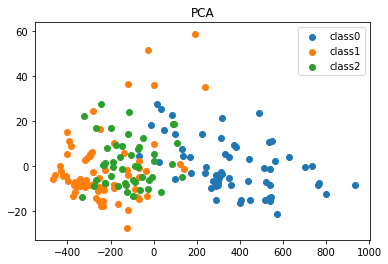

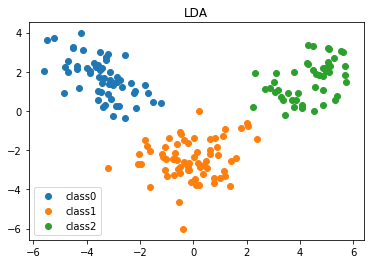

In [57]:
def plot_PCA_LDA(wine_pca, wine_lda):
    """
    Use a scatter plot to plot PCA and LDA components obtained using the functions above.
    Use a different color for each class.
    """
    plt.title("PCA")
    #plt.subplots(2,1,1)
    for i in range(3):
        wine_PCA=wine_pca[y==i]
        plt.scatter(wine_PCA[:,0],wine_PCA[:,1])
    plt.legend(['class0','class1','class2'])
    #plt.subplots(2,1,2)
    plt.figure()
    plt.title("LDA")
    for i in range(3):
        wine_LDA=wine_lda[y==i]
        plt.scatter(wine_LDA[:,0],wine_LDA[:,1])
    plt.legend(['class0','class1','class2'])
    plt.show()
    
    #raise NotImplementedError
    
plot_PCA_LDA(wine_pca, wine_lda)

Which dimensionality reduction method is better? Why？[5pts]


LDA perform better. As you can see in LDA chart, compared to PCA, the the distance between objects belong to the same class is closer while the distance between other classes is farther.
PCA will perform better when number of sample per class is less. When there is largedataset having multiple classes, LDA will work better. 
